<a href="https://colab.research.google.com/github/josephxlp/FinMLA/blob/main/Stock_Sentiment_Analysis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk gensim transformers --q

In [ ]:
from google.colab import drive
from pathlib import Path
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from wordcloud import WordCloud, STOPWORDS
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
rootpath = Path("/content/drive/MyDrive/portfolio/FinMLA")
datapath = rootpath / 'data'

In [ ]:
stock_sentiment_df = pd.read_csv(datapath/"stock_sentiment.csv")

In [ ]:
df = stock_sentiment_df.copy()

In [ ]:
df.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [ ]:
df.columns = ['text','sentiment']

In [ ]:
df.sentiment.value_counts()

,count
sentiment,
1,3685
0,2106


In [ ]:
df.isna().sum()

,0
text,0
sentiment,0


In [ ]:
def remove_punctuation_from_text(text):
  txt_prox = [char for char in text if char not in string.punctuation]
  txt_join = ''.join(txt_prox)
  return txt_join

In [ ]:
df['string_text'] = df['text'].apply(remove_punctuation_from_text)

In [ ]:
df.sample(1).values

array([['ZNGA Wants to breakout. 3.76 is short-term resistance.  ', 1,
        'ZNGA Wants to breakout 376 is shortterm resistance  ']],
      dtype=object)

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day',
                   'user','stock','today','week','year'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def remove_stopwords(text):
  out = []
  for token in gensim.utils.simple_preprocess(text):
    if len(token) >= 2 and token not in stop_words:
      out.append(token)
  return out

In [ ]:
df['gensim_text'] = df['string_text'].apply(remove_stopwords)

In [ ]:
df.sample(1).values.tolist()

[['AAP here come the Europeans.. maybe they will save us?',
  1,
  'AAP here come the Europeans maybe they will save us',
  ['come', 'europeans', 'maybe', 'save', 'us']]]

In [ ]:
df['gensim_text_join'] = df['gensim_text'].apply(lambda x: " ".join(x))

In [ ]:
df.sample(1).values.tolist()

[['DA nice run from entry; moving stop up to breakeven  ',
  1,
  'DA nice run from entry moving stop up to breakeven  ',
  ['da', 'nice', 'run', 'entry', 'moving', 'stop', 'breakeven'],
  'da nice run entry moving stop breakeven']]

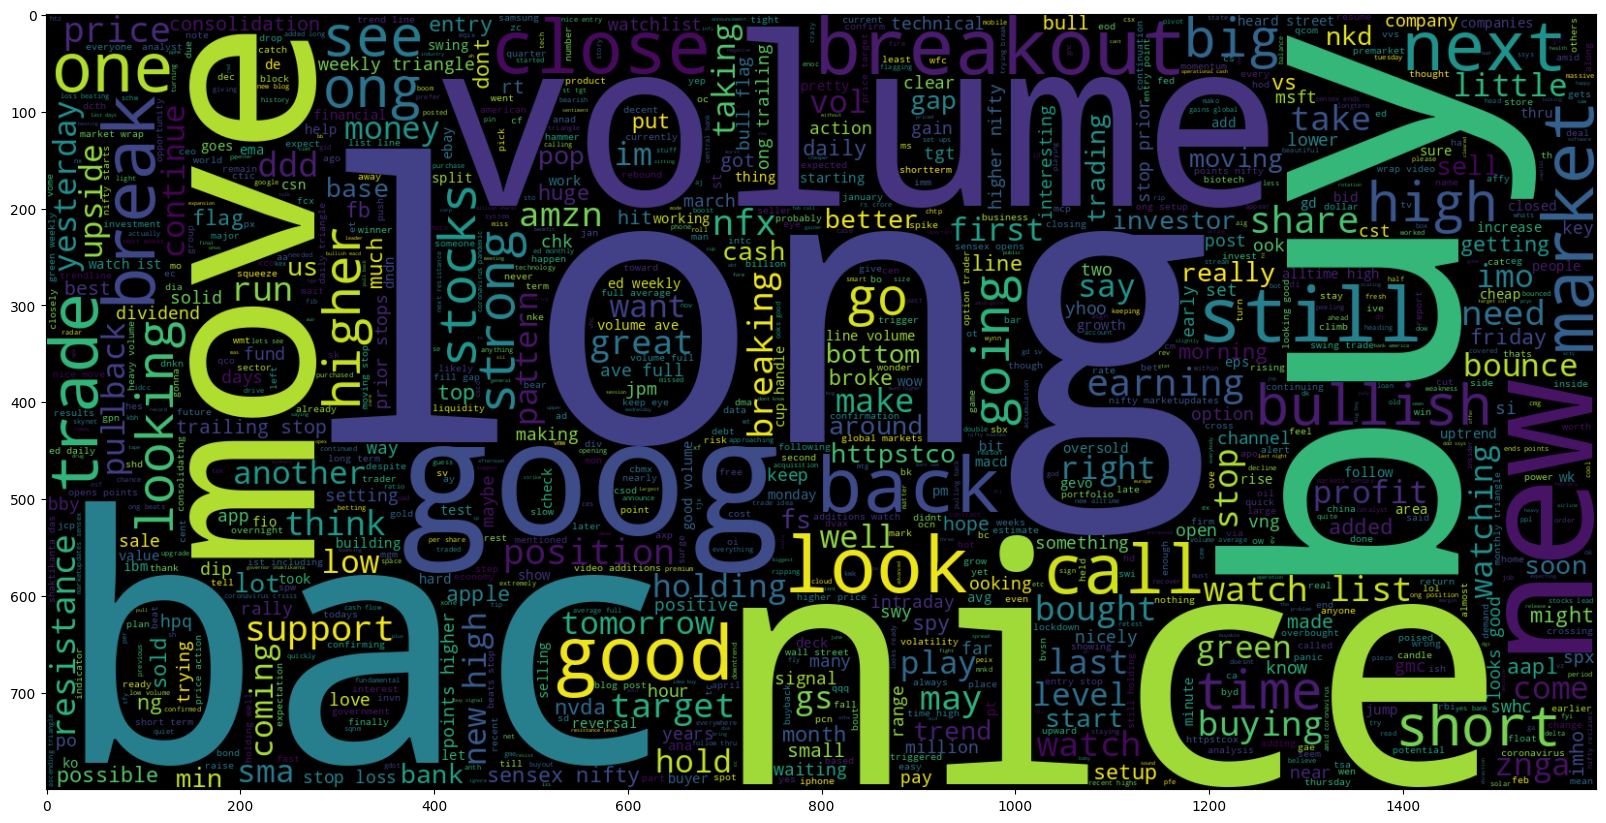

In [ ]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df[df['sentiment'] == 1]['gensim_text_join']))
plt.imshow(wc, interpolation = 'bilinear');

In [ ]:
# word_tokenize is used to break up a string into words
print(df['gensim_text_join'][0])
print(nltk.word_tokenize(df['gensim_text_join'][0]))

kickers watchlist xide tit soq pnk cpw bpz aj trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'aj', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [ ]:

# Obtain the maximum length of data in the document
# This will be later used when word embeddings are generated
maxlen = -1
for doc in df['gensim_text_join']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 22


In [ ]:
df['text_length'] = [ len(nltk.word_tokenize(x)) for x in df['gensim_text_join'] ]
df.head(4)

,text,sentiment,string_text,gensim_text,gensim_text_join,text_length
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz aj ...,15
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome,6
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[id, afraid, short, amzn, looking, like, nearm...",id afraid short amzn looking like nearmonopoly...,8
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta,1


In [ ]:
fig = px.histogram(x = df['text_length'].tolist(), nbins = 50)
fig.show()

In [ ]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df['gensim_text']:
  for j in i:
        list_of_words.append(j)

# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

9647

In [ ]:
X = df['gensim_text']
y = df['sentiment']

In [ ]:
from sklearn.model_selection import train_test_split
trainx, testx, trainy, testy = train_test_split(X, y, test_size = 0.1, random_state=42)

In [ ]:
# create a pipeline

In [ ]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(trainx) # how to save this as pickle so it can be use in production?

# Training data
trainx_sequences = tokenizer.texts_to_sequences(trainx)

# Testing data
testx_sequences = tokenizer.texts_to_sequences(testx)


In [ ]:
trainx_sequences[:3]

[[464, 253, 2649, 37, 13],
 [3850, 3851, 1054, 748, 155, 440, 112, 41, 56, 71, 78],
 [68, 196, 15, 306]]

In [ ]:
testx_sequences[4:7]

[[11, 29, 2602, 23, 160, 160],
 [2070, 783, 54, 378, 256, 482, 6464, 130, 41],
 [8634, 2568, 963, 1085, 372, 117, 246, 143, 117, 246]]

In [ ]:
print("The encoding for document\n", trainx[1:2],"\n is: ", trainx_sequences[1])

The encoding for document
 1073    [bzh, beazer, homes, sa, option, traders, gett...
Name: gensim_text, dtype: object 
 is:  [3850, 3851, 1054, 748, 155, 440, 112, 41, 56, 71, 78]


In [ ]:
# Add padding to training and testing
trainx_pad = pad_sequences(trainx_sequences, maxlen=29, padding='post',truncating='post')
testx_pad = pad_sequences(testx_sequences, maxlen=29, padding='post')

In [ ]:
# Convert the data to categorical 2D representation
trainy_cat = to_categorical(trainy, 2)
testy_cat = to_categorical(testy, 2)

In [ ]:
trainx_pad.shape, trainy_cat.shape,

((5211, 29), (5211, 2))

In [ ]:
trainx_pad[:3]

array([[ 464,  253, 2649,   37,   13,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [3850, 3851, 1054,  748,  155,  440,  112,   41,   56,   71,   78,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  68,  196,   15,  306,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
trainy_cat[:3]

array([[1., 0.],
       [0., 1.],
       [0., 1.]])

- LSTM
- Transformer

In [ ]:
# Sequential Model
model = Sequential()

# embedding layer
model.add(Embedding(total_words, output_dim = 512))

# Bi-Directional RNN and LSTM
model.add(LSTM(256))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Nepoch = 10
BatchS = 32

In [ ]:
model.fit(trainx_pad, trainy_cat, batch_size = BatchS, validation_split = 0.2,
          epochs = Nepoch)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 270ms/step - acc: 0.9138 - loss: 0.2444 - val_acc: 0.7287 - val_loss: 0.6647
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 275ms/step - acc: 0.9588 - loss: 0.1144 - val_acc: 0.7584 - val_loss: 0.9973
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 256ms/step - acc: 0.9806 - loss: 0.0551 - val_acc: 0.7162 - val_loss: 1.0777
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 267ms/step - acc: 0.9914 - loss: 0.0262 - val_acc: 0.7459 - val_loss: 1.3914
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - acc: 0.9951 - loss: 0.0146 - val_acc: 0.7239 - val_loss: 1.5574
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 257ms/step - acc: 0.9931 - loss: 0.0216 - val_acc: 0.7450 - val_loss: 1.8717
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 250ms/step - acc: 0.9933 - loss: 0.0224 - val_acc: 0.7430 - val_loss: 1.4096
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - acc: 0.9975 - loss: 0.0071 - val_acc: 0.7325 - val_loss: 1.4605
Epoch 9/10
131/131 ━━━━━━━━━━━━━

In [ ]:
pred = model.predict(testx_pad)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step


In [ ]:
pred.shape

(580, 2)

In [ ]:
def prediction2d_to_vector(prediction2d):
  prediction = []
  for i in prediction2d:
    prediction.append(np.argmax(i))
  return prediction

In [ ]:
testp = prediction2d_to_vector(pred)
len(testp)

580

In [ ]:
testy.shape

(580,)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def classification_report_df(y_true, y_pred):
  # Calculate metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Define meanings based on scores
  def interpret_score(score):
      if score >= 0.9:
          return "Excellent"
      elif score >= 0.8:
          return "Very Good"
      elif score >= 0.7:
          return "Good"
      elif score >= 0.6:
          return "Fair"
      else:
          return "Poor"

  # Create a DataFrame
  report_df = pd.DataFrame({
      'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
      'Score': [accuracy, precision, recall, f1],
      'Meaning': [interpret_score(accuracy), interpret_score(precision),
                  interpret_score(recall), interpret_score(f1)]
  })

  # Add confusion matrix to the DataFrame
  conf_matrix_df = pd.DataFrame(conf_matrix,
                                index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])

  return report_df, conf_matrix_df


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def classification_report_df(y_true, y_pred):
  # Calculate metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Define meanings based on scores
  def interpret_score(score):
      if score >= 0.9:
          return "Excellent"
      elif score >= 0.8:
          return "Very Good"
      elif score >= 0.7:
          return "Good"
      elif score >= 0.6:
          return "Fair"
      else:
          return "Poor"

  # Create a DataFrame
  report_df = pd.DataFrame({
      'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
      'Score': [accuracy, precision, recall, f1],
      'Meaning': [interpret_score(accuracy), interpret_score(precision),
                  interpret_score(recall), interpret_score(f1)]
  })

  # Plot confusion matrix
  fig = plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['Actual Negative', 'Actual Positive'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  #plt.show()

  # Interpretation text
  interpretation_text = (
      f"Accuracy: {interpret_score(accuracy)}\n"
      f"Precision: {interpret_score(precision)}\n"
      f"Recall: {interpret_score(recall)}\n"
      f"F1 Score: {interpret_score(f1)}"
  )
  print("Interpretation of Metrics:")
  print(interpretation_text)

  conf_matrix_df = pd.DataFrame(conf_matrix,
                                index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])

  return report_df,conf_matrix_df,fig

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def classification_report_df(y_true, y_pred):
  # Calculate metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Define meanings based on scores
  def interpret_score(score):
      if score >= 0.9:
          return "Excellent"
      elif score >= 0.8:
          return "Very Good"
      elif score >= 0.7:
          return "Good"
      elif score >= 0.6:
          return "Fair"
      else:
          return "Poor"

  # Create a DataFrame
  report_df = pd.DataFrame({
      'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
      'Score': [accuracy, precision, recall, f1],
      'Meaning': [interpret_score(accuracy), interpret_score(precision),
                  interpret_score(recall), interpret_score(f1)]
  })

  # Plot confusion matrix
  fig = plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['Actual Negative', 'Actual Positive'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  # Interpretation of the confusion matrix
  tn, fp, fn, tp = conf_matrix.ravel()
  interpretation_text = (
      f"True Positives (TP): {tp} - Correctly predicted positive cases.\n"
      f"True Negatives (TN): {tn} - Correctly predicted negative cases.\n"
      f"False Positives (FP): {fp} - Incorrectly predicted as positive (Type I error).\n"
      f"False Negatives (FN): {fn} - Incorrectly predicted as negative (Type II error).\n"
      f"To improve results, aim to reduce FP and FN by enhancing model precision and recall."
  )
  print("Interpretation of Confusion Matrix:")
  print(interpretation_text)
  conf_matrix_df = pd.DataFrame(conf_matrix,
                                index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])

  return report_df,conf_matrix_df,fig


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def classification_report_df(y_true, y_pred):
  # Calculate metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Define meanings based on scores
  def interpret_score(score):
      if score >= 0.9:
          return "Excellent"
      elif score >= 0.8:
          return "Very Good"
      elif score >= 0.7:
          return "Good"
      elif score >= 0.6:
          return "Fair"
      else:
          return "Poor"

  # Create a DataFrame
  report_df = pd.DataFrame({
      'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
      'Score': [accuracy, precision, recall, f1],
      'Meaning': [interpret_score(accuracy), interpret_score(precision),
                  interpret_score(recall), interpret_score(f1)]
  })

  # Plot confusion matrix
  fig = plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['Actual Negative', 'Actual Positive'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  # Interpretation of the confusion matrix
  tn, fp, fn, tp = conf_matrix.ravel()
  interpretation_text = (
      f"True Positives (TP): {tp} - Correctly predicted positive cases.\n"
      f"True Negatives (TN): {tn} - Correctly predicted negative cases.\n"
      f"False Positives (FP): {fp} - Incorrectly predicted as positive (Type I error).\n"
      f"False Negatives (FN): {fn} - Incorrectly predicted as negative (Type II error).\n\n"
      f"**Metrics Relationship:**\n"
      f"- **Precision** (TP / (TP + FP)): Measures the accuracy of positive predictions. High precision indicates a low false positive rate.\n"
      f"- **Recall** (TP / (TP + FN)): Measures the ability to find all positive samples. High recall indicates a low false negative rate.\n"
      f"- **Accuracy** ((TP + TN) / Total): Overall correctness of the model. It can be misleading if classes are imbalanced.\n"
      f"- **F1 Score**: Harmonic mean of precision and recall, useful for imbalanced classes.\n\n"
      f"**Improvement Suggestions:**\n"
      f"To improve the model, focus on increasing precision and recall by reducing FP and FN. This can be achieved by tuning the model, using more data, or selecting better features."
  )
  print("Interpretation of Confusion Matrix:")
  print(interpretation_text)

  conf_matrix_df = pd.DataFrame(conf_matrix,
                                index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])

  return report_df, conf_matrix_df, fig

# Example usage
# y_true = [actual labels]
# y_pred = [predicted labels]
# report, conf_matrix_df, fig = classification_report_df(y_true, y_pred)
# print(report)

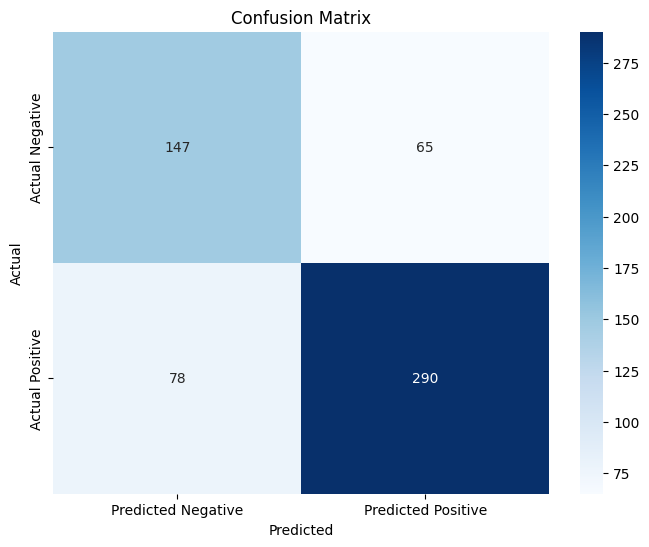

Interpretation of Confusion Matrix:
True Positives (TP): 290 - Correctly predicted positive cases.
True Negatives (TN): 147 - Correctly predicted negative cases.
False Positives (FP): 65 - Incorrectly predicted as positive (Type I error).
False Negatives (FN): 78 - Incorrectly predicted as negative (Type II error).

**Metrics Relationship:**
- **Precision** (TP / (TP + FP)): Measures the accuracy of positive predictions. High precision indicates a low false positive rate.
- **Recall** (TP / (TP + FN)): Measures the ability to find all positive samples. High recall indicates a low false negative rate.
- **Accuracy** ((TP + TN) / Total): Overall correctness of the model. It can be misleading if classes are imbalanced.
- **F1 Score**: Harmonic mean of precision and recall, useful for imbalanced classes.

**Improvement Suggestions:**
To improve the model, focus on increasing precision and recall by reducing FP and FN. This can be achieved by tuning the model, using more data, or selecting 

In [ ]:
# acuracy score on text data
from sklearn.metrics import accuracy_score
report_df, cm_df,cm_fig = classification_report_df(testy,testp)

In [ ]:
report_df

,Metric,Score,Meaning
0,Accuracy,0.753448,Good
1,Precision,0.816901,Very Good
2,Recall,0.788043,Good
3,F1 Score,0.802213,Very Good


In [ ]:
from transformers import pipeline

In [ ]:
nlp = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [ ]:
nlp = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# try:
#   testp_transforms_default = nlp(list(testx))
# except:
#   testp_transforms_default = nlp(list(testx.values))